### Comparison of regular and focused single-channel optimizations

In [2]:
#import packages

import matplotlib.pyplot as plt
from matplotlib import patches
import pygimli as pg
import numpy as np
import pygimli.meshtools as mt
import optimize

Mesh: Nodes: 332 Cells: 555 Boundaries: 886


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>, None)

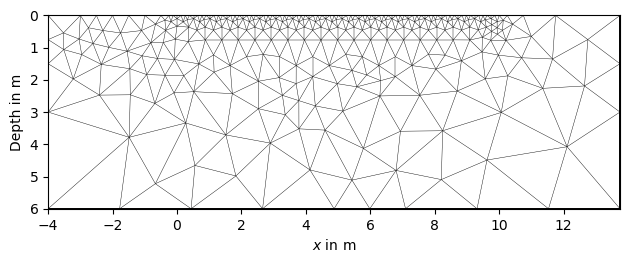

In [3]:
#create simple triangular grid with 20 electrodes
world = mt.createWorld(start=[-4, 0], end=[13.75, -6],
                       worldMarker=True)

nelecs=20
pos = np.zeros((nelecs, 2))
pos[:, 0] = np.linspace(0, 9.75, nelecs)

for p in pos:
    world.createNode(p)
    world.createNode(p - [0, 0.1])

mesh = mt.createMesh(world, quality=34)
print(mesh)
pg.show(mesh,showNodes=True)

In [4]:
#SET RESISTIVITY OF BACKGROUND
rholist = [[1,100]]
rho = pg.solver.parseMapToCellArray(rholist, mesh)

In [5]:
#load regular optimized scheme

config_opt = np.loadtxt("optimizations/singlechannel/v1_0_0/opt_scheme.dat")
#minus one to put configuration into pygimli electrode format
config_opt = config_opt-1

#create ert scheme and calculate jacobian and resolution matrix
scheme = pg.DataContainerERT()
scheme.setSensorPositions(pos)
scheme.resize(len(config_opt))
for i, j in enumerate("abmn"):
    scheme.set(j, config_opt[:, i])

scheme.set("valid", np.ones(len(config_opt)))

fop = optimize.init_model(scheme, mesh, irm=False)
fop.createJacobian(rho)
J = np.array(fop.jacobian())
#for visualization, we want the sensitivities to be weighed by the cell size
meshsize = np.array(pg.Vector(mesh.cellSizes()))
sizefactor = 1/meshsize
sizefactor = np.tile(sizefactor, (len(J),1))
J = J*sizefactor
#for constaints, we chose second order smoothing (I think here, the irregular grid is not accounted for...)
WTW = optimize.create_constraints(fop, 2)

#CALCULATE RESOLUTION MATRIX
R = optimize.calc_R(J,WTW,lam=10**-6)
R_diag = np.diag(R)

23/08/24 - 16:08:52 - pyGIMLi - INFO - Found 1 regions.
23/08/24 - 16:08:52 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/08/24 - 16:08:52 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


23/08/24 - 16:08:52 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1218 Cells: 2220 Boundaries: 1772


ModellingBase::setMesh() copying new mesh ... Found datafile: 20 electrodes
Found: 20 free-electrodes
rMin = 0.256579, rMax = 19.5
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00535038 s
FOP updating mesh dependencies ... 3.27e-06 s
Creating new subpotentials for createJacobian.
Subpotentials matrix is empty.
Calculating subpotentials analytical for createJacobian: 1 (top: 0|cem: 0|het: 0)
Obtaining geometric factors (analytical)
Allocating memory for primary potential...... 0.00030834

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.0452038s
Scale subpotentials with 100
S(64/64-std::mt): 0.00229373:time: 0.036465s
sens sum: median = 1.00351 min = 0.637861 max = 5.04461


In [6]:
#same procedure for the focused optimized scheme
#load focused optimized scheme
config_opt_focus = np.loadtxt("optimizations/singlechannel/v1_focus_0_0/opt_scheme.dat")
#minus one to put into pygimli electrode format
config_opt_focus = config_opt_focus-1

scheme_foc = pg.DataContainerERT()
scheme_foc.setSensorPositions(pos)
scheme_foc.resize(len(config_opt_focus))
for i, j in enumerate("abmn"):
    scheme_foc.set(j, config_opt_focus[:, i])

scheme_foc.set("valid", np.ones(len(config_opt_focus)))

#CALCULATE JACOBIAN AND CONSTRAINTS
fop_foc = optimize.init_model(scheme_foc, mesh, irm=False)
fop_foc.createJacobian(rho)
J_foc = np.array(fop_foc.jacobian())
meshsize = np.array(pg.Vector(mesh.cellSizes()))
sizefactor = 1/meshsize
sizefactor = np.tile(sizefactor, (len(J_foc),1))
J_foc = J_foc*sizefactor
WTW_foc = optimize.create_constraints(fop_foc, 2)
#CALCULATE RESOLUTION MATRIX
R_foc = optimize.calc_R(J_foc,WTW,lam=10**-6)
R_foc_diag = np.diag(R_foc)

23/08/24 - 16:08:53 - pyGIMLi - INFO - Found 1 regions.
23/08/24 - 16:08:53 - pyGIMLi - INFO - Creating forward mesh from region infos.
23/08/24 - 16:08:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
23/08/24 - 16:08:53 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 1218 Cells: 2220 Boundaries: 1772


ModellingBase::setMesh() copying new mesh ... Found datafile: 20 electrodes
Found: 20 free-electrodes
rMin = 0.256579, rMax = 19.5
NGauLeg + NGauLag for inverse Fouriertransformation: 11 + 4
Found non-Neumann domain
0.00509645 s
FOP updating mesh dependencies ... 3.2e-06 s
Creating new subpotentials for createJacobian.
Subpotentials matrix is empty.
Calculating subpotentials analytical for createJacobian: 1 (top: 0|cem: 0|het: 0)
Obtaining geometric factors (analytical)
Allocating memory for primary potential...... 0.00028187

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.0446681s
Scale subpotentials with 100
S(64/64-std::mt): 0.00241563:time: 0.0324586s
sens sum: median = 1.0006 min = 0.0691653 max = 5.09514


/tmp/ipykernel_51576/4602521.py:5: RuntimeWarning: invalid value encountered in log10
  pg.show(mesh,np.log10(R_foc_diag),ax=axes[1],cMap='turbo',cMin=-4,cMax=0, label=r'$log_{10}(R_{diag})$')


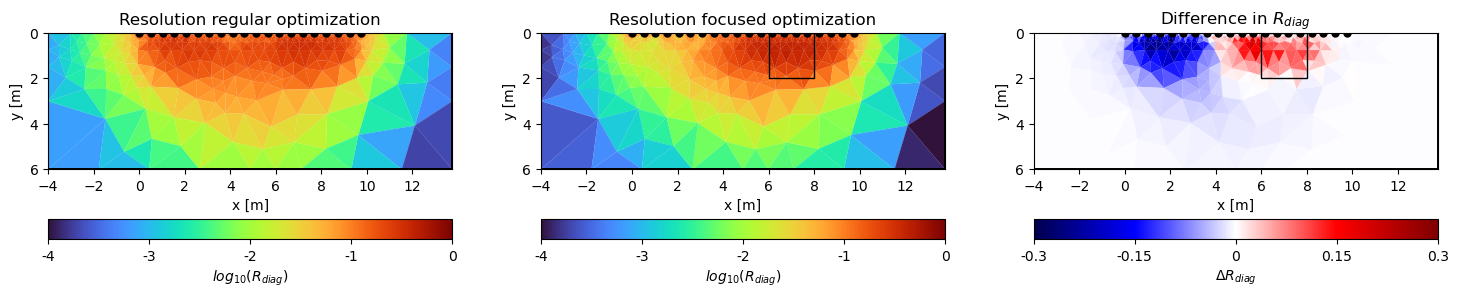

In [7]:
#Plot results with regular set on the left, focused set in the middle and the absolute difference between both on the right

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
pg.show(mesh,np.log10(R_diag),ax=axes[0],cMap='turbo',cMin=-4,cMax=0, label=r'$log_{10}(R_{diag})$')
pg.show(mesh,np.log10(R_foc_diag),ax=axes[1],cMap='turbo',cMin=-4,cMax=0, label=r'$log_{10}(R_{diag})$')
pg.show(mesh,R_foc_diag-R_diag,ax=axes[2],cMap='seismic',cMin=-0.3,cMax=0.3,label='$\Delta R_{diag}$')#,cMin=-4,cMax=0, label=r'$log_{10}(R_{diag})$')

for ax in axes.flat:
    ax.set(xlabel='x [m]', ylabel='y [m]')
    #ax.set_xlim(-2,11.75)
    #ax.set_ylim(-4,0)
    for p in pos:
        ax.plot(p[0],p[1],'ko',markersize=5)
rect = patches.Rectangle((6, -2), 2, 2, linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((6, -2), 2, 2, linewidth=1, edgecolor='k', facecolor='none')
axes[1].add_patch(rect)
axes[2].add_patch(rect2)
axes[0].set_title(r'Resolution regular optimization')
axes[1].set_title(r'Resolution focused optimization')
axes[2].set_title(r'Difference in $R_{diag}$')
fig.tight_layout()
fig.savefig('resolution_matrix.png', dpi=300)